<a href="https://colab.research.google.com/github/Ananthu89/James-Dalal-Kousi-et-al-BJMGH-2022/blob/main/Standard_vs_beta_VAEs/Beta_versus_normal_VAE_2D_Latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu


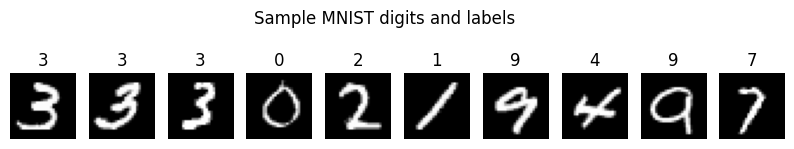

In [ ]:
# Full Standalone Script to Load and Visualize MNIST (Before Applying VAE)

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ====== Load MNIST ======
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ====== Visualize a few samples ======
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(str(example_targets[i].item()))
plt.suptitle("Sample MNIST digits and labels")
plt.show()

In [ ]:
# Full VAE Script for MNIST with Plot Saving (Google Colab Compatible)

# ====== Install and Import ======
!pip install -q torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# ====== Google Drive Mount (Optional) ======
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/vae_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# ====== Device Setup ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Load MNIST Dataset ======
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ====== Define VAE Model ======
class VAE(nn.Module):
    def __init__(self, beta=1.0):
        super(VAE, self).__init__()
        self.beta = beta
        self.fc1 = nn.Linear(28*28, 256)
        self.fc21 = nn.Linear(256, 2)  # mu
        self.fc22 = nn.Linear(256, 2)  # logvar
        self.fc3 = nn.Linear(2, 256)
        self.fc4 = nn.Linear(256, 28*28)
        # This is a Multi-Layer Perceptron or MLP (fully connected layer) with just a 2D latent space

    def encode(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 28*28)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ====== Loss Function ======
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

# ====== Train Function ======
def train_vae(model, optimizer, epochs=50):
    model.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, model.beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch:3d} / {epochs} | Loss: {train_loss/len(train_loader.dataset):.4f}')

# ====== Plot Latent Space ======
def plot_latent_space(model, title, save_path):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, _ = model.encode(x.view(-1, 28*28))
            zs.append(mu.cpu())
            labels.append(y)
    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(5,5))
    plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap='tab10', s=2, alpha=0.6)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True)
    plt.savefig(save_path, dpi=300)
    plt.close()

# ====== Initialize Models ======
vae_vanilla = VAE(beta=1.0).to(device)
vae_b1_5    = VAE(beta=1.5).to(device)
vae_b4      = VAE(beta=4.0).to(device)

opt_vanilla = torch.optim.Adam(vae_vanilla.parameters(), lr=1e-3)
opt_b1_5    = torch.optim.Adam(vae_b1_5.parameters(), lr=1e-3)
opt_b4      = torch.optim.Adam(vae_b4.parameters(), lr=1e-3)

# ====== Train All Models ======
print("Training Vanilla VAE (β=1)")
train_vae(vae_vanilla, opt_vanilla)

print("\nTraining β-VAE (β=1.5)")
train_vae(vae_b1_5, opt_b1_5)

print("\nTraining β-VAE (β=4)")
train_vae(vae_b4, opt_b4)

# ====== Save All Latent Space Plots ======
plot_latent_space(vae_vanilla, "Vanilla VAE (β=1)",   os.path.join(SAVE_DIR, "latent_beta_1.png"))
plot_latent_space(vae_b1_5,    "β-VAE (β=1.5)",        os.path.join(SAVE_DIR, "latent_beta_1.5.png"))
plot_latent_space(vae_b4,      "β-VAE (β=4)",          os.path.join(SAVE_DIR, "latent_beta_4.png"))

print("\nAll done. Plots saved to Google Drive -> vae_outputs/")



Mounted at /content/drive
Training Vanilla VAE (β=1)
Epoch   1 / 50 | Loss: 197.9639
Epoch   2 / 50 | Loss: 170.2155
Epoch   3 / 50 | Loss: 165.7907
Epoch   4 / 50 | Loss: 163.7637
Epoch   5 / 50 | Loss: 162.2484
Epoch   6 / 50 | Loss: 161.1188
Epoch   7 / 50 | Loss: 160.0095
Epoch   8 / 50 | Loss: 159.1012
Epoch   9 / 50 | Loss: 158.1964
Epoch  10 / 50 | Loss: 157.4230
Epoch  11 / 50 | Loss: 156.6738
Epoch  12 / 50 | Loss: 156.0196
Epoch  13 / 50 | Loss: 155.5386
Epoch  14 / 50 | Loss: 155.0242
Epoch  15 / 50 | Loss: 154.5838
Epoch  16 / 50 | Loss: 154.1069
Epoch  17 / 50 | Loss: 153.7687
Epoch  18 / 50 | Loss: 153.4252
Epoch  19 / 50 | Loss: 153.0696
Epoch  20 / 50 | Loss: 152.7559
Epoch  21 / 50 | Loss: 152.4754
Epoch  22 / 50 | Loss: 152.1778
Epoch  23 / 50 | Loss: 151.9096
Epoch  24 / 50 | Loss: 151.6730
Epoch  25 / 50 | Loss: 151.3763
Epoch  26 / 50 | Loss: 151.1685
Epoch  27 / 50 | Loss: 151.0023
Epoch  28 / 50 | Loss: 150.7486
Epoch  29 / 50 | Loss: 150.4956
Epoch  30 / 50 | Lo